# Project "Sales funnel research and decision-making based on A/A/B tests"

# Project Description
We work in a startup that sells food. We need to figure out how the users of our mobile application behave. 
Let's study the sales funnel. Let's find out how users reach the purchase. How many users reach the purchase, and how many are "stuck" in the previous steps? Which ones exactly?
After that, we will investigate the results of the A/A/B experiment. Designers wanted to change fonts throughout the application, and managers were afraid that users would be unusual. We agreed to make a decision based on the results of the A/A/B test. Users were divided into 3 groups: 2 control ones with old fonts and one experimental one with new ones. Let's find out which font is better.

# Data description
Each log entry is a user action or event. 
- EventName — event name
- DeviceIDHash — unique user ID
- EventTimestamp — event time
- ExpId — experiment number: 246 and 247 are control groups, and 248 is experimental.

# Work plan:
1. Open the data file and study the general information
2. We will perform data preprocessing, try to fill in the gaps, check the data for the presence of explicit and implicit duplicates, change the data type if necessary.
3. Examine and verify the data
Let's check how many events there are in the log;
Let's check how many users there are in the log;
Let's check the average number of events per user;
Let's check the data for what period we have;
Let's determine from what moment the data is complete and discard the older ones;
Let's check how many events and users we lost by discarding the old data;
Let's check that we have users from all three experimental groups;
4. Let's study the funnel of events
Let's see what events are in the logs, how often they occur;
Let's count how many users committed each of these events;
Let's calculate the proportion of users who have ever committed an event;
Let's assume in what order the events occur and build a funnel of events;
Using the funnel of events, we will calculate what proportion of users passes to the next step of the funnel;
Let's determine at which step you lose the most users;
Let's check what percentage of users reaches from the first event to the payment;
5. Let's study the results of the experiment
Let's check how many users are in each experimental group;
Let's conduct an A/A test, check whether statistical criteria find the difference between samples 246 and 247;
We will conduct an A/B test, check whether the statistical criteria find the difference between the combined control group and the experimental group;
6. We will write a conclusion about the information received during the study.

## Step 1. Open the files and study the general information

In [1]:
# Importing the libraries that we will need in this project 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import math as mth
from scipy import stats as st
import seaborn as sb
from plotly import graph_objects as go
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 400

In [2]:
# Let's read the data from the csv file into a dataframe and save it to a variable
try:
    data = pd.read_csv('logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [3]:
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


#### Conclusion: at this stage, we have opened the dataset and studied the general information about the source data

## Step 2. Perform data preprocessing

In [5]:
# Rename the column names in the table
data = data.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 
                              'EventTimestamp': 'event_timestamp', 'ExpId': 'group'})

In [6]:
# Let's check how many gaps there are in our table
data.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

**Conclusion: no omissions were detected.**

In [7]:
# Let's check how many explicit duplicates there are in our table
data.duplicated().sum()

413

In [8]:
# Let's calculate the proportion of explicit duplicates
round(data.duplicated().mean() * 100, 2)

0.17

In [9]:
# Remove explicit duplicates from the table
data = data.drop_duplicates()
data = data.reset_index(drop=True)

In [10]:
# Let's check that the deletion went correctly
data.duplicated().sum()

0

In [11]:
# Let's check for implicit duplicates in the event_name column
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

**No implicit duplicates were found in the event_name column.**

In [12]:
# Let's check for implicit duplicates in the group column
data['group'].unique()

array([246, 248, 247], dtype=int64)

**No implicit duplicates were found in the group column, all values correspond to the condition.**

In [13]:
# Add a column with date and time
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')

In [14]:
# Add a column with the date
data['date'] = data['date_time'].dt.floor('D')

In [15]:
data.head(10)

,event_name,user_id,event_timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 11:48:43,2019-07-25
6,OffersScreenAppear,8351860793733343758,1564066242,246,2019-07-25 14:50:42,2019-07-25
7,MainScreenAppear,5682100281902512875,1564085677,246,2019-07-25 20:14:37,2019-07-25
8,MainScreenAppear,1850981295691852772,1564086702,247,2019-07-25 20:31:42,2019-07-25
9,MainScreenAppear,5407636962369102641,1564112112,246,2019-07-26 03:35:12,2019-07-26


In [16]:
# Let's check for which days we have data in the table
data.groupby('date')['user_id'].nunique()

date
2019-07-25       7
2019-07-26      22
2019-07-27      39
2019-07-28      69
2019-07-29     135
2019-07-30     296
2019-07-31     924
2019-08-01    3703
2019-08-02    3647
2019-08-03    3482
2019-08-04    3527
2019-08-05    3802
2019-08-06    3922
2019-08-07    3651
Name: user_id, dtype: int64

**Conclusion: the table shows data from July 25, 2019 to August 7, 2019**

#### Conclusion: at this stage, we have studied the general information about the source data, checked for gaps in the tables, checked the data for duplicates. 413 explicit duplicates were detected and removed. No implicit duplicates or omissions were found.

## Step 3. Examine and verify the data

##### Let's count how many events there are in the log

In [17]:
data['event_name'].count()

243713

**The table shows 243,713 logs.** 

##### Let's calculate how many unique users there are in the log

In [18]:
data['user_id'].nunique()

7551

**The table shows 7,551 unique users.** 

##### Let's calculate the average number of events per user

In [19]:
round(data['event_name'].count() / data['user_id'].nunique(), 2)

32.28

**On average, there are 32 events per user.** 

In [20]:
data.head()

,event_name,user_id,event_timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


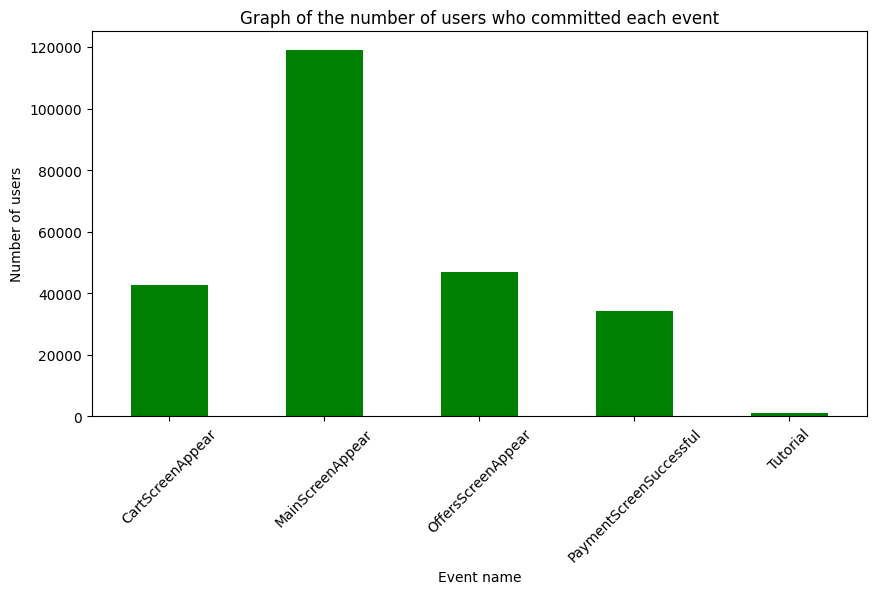

In [21]:
# Let's build how many total users (non-unique) committed each event
data.pivot_table(index='event_name', values='user_id', aggfunc=['count']).\
plot(grid=False, 
figsize=(10, 5), kind='bar', 
title='Graph of the number of users who committed each event', rot=45, legend = None, color='green')
plt.xlabel("Event name")
plt.ylabel("Number of users")
plt.show();

##### Let's determine the data for what period we have

In [22]:
# Find the maximum and minimum dates
display(data['date'].min())
data['date'].max()

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

**Conclusion: the table shows data from July 25, 2019 to August 7, 2019.**

In [23]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [24]:
data.head()

,event_name,user_id,event_timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


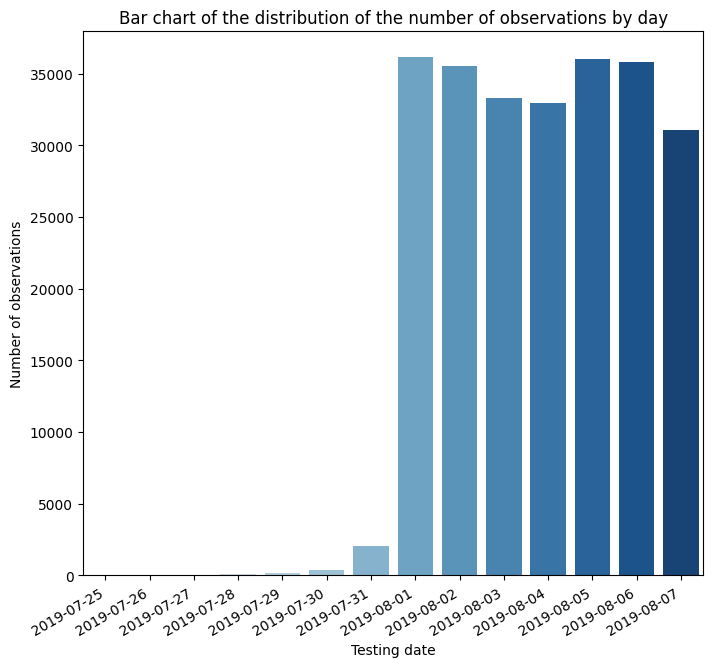

In [62]:
# For better clarity, let's build a bar chart

fig, ax = plt.subplots(figsize=(8, 8))

ax = sb.countplot(x = "date", data = data, palette = "Blues")
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])
fig.autofmt_xdate()
plt.xlabel('Testing date')
plt.ylabel('Number of observations')
plt.title('Bar chart of the distribution of the number of observations by day')
plt.show();

**We see that the amount of data is increasing dramatically starting from August 1, 2019.** 

In [26]:
# Let's count the number of events for each date
data.groupby('date')['event_name'].count()

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_name, dtype: int64

**In my opinion, until August 1, 2019, the data is incomplete and they need to be discarded.** 

In [27]:
data_new = data.query('date >= "2019-08-01"')

##### Let's determine how many events and users we have lost

In [28]:
round(100 * (1 - data_new['event_name'].count() / data['event_name'].count()), 2)

1.16

In [29]:
round(100 * (1 - data_new['user_id'].nunique() / data['user_id'].nunique()), 2)

0.23

**Conclusion: we lost 1% of events and less than 1% of users.**

##### Let's check that we have users from all three experimental groups.

In [30]:
data_new.pivot_table(index='group', values=['user_id'], aggfunc=['nunique']).reset_index()

,group,nunique
,,user_id
0,246,2484
1,247,2513
2,248,2537


#### Conclusion: we have studied the data. We were able to establish the following:
1. The table shows 243,713 logs and 7,551 unique users.
2. It was determined that on average there are 32 events per user.
3. It was determined that the data were incomplete before August 1, 2019 and it was decided to exclude them from further consideration.

## Step 4. Let's study the funnel of events

##### Let's check what events are in the logs, how often they occur

In [31]:
data_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

##### Let's count how many users committed each of these events

In [32]:
users_with_actions = data_new.pivot_table(
            index='event_name', values='user_id', aggfunc='nunique'
        )
users_with_actions.sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [33]:
# Let's calculate the proportion of users who have ever committed an event
users_with_actions['percentage'] = round(100 * (users_with_actions['user_id'] / data_new['user_id'].nunique()), 2)
users_with_actions.sort_values(by='percentage', ascending=False)

,user_id,percentage
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


##### Apparently, the Tutorial event is not a mandatory event for users, so we will exclude it when calculating the funnel.

In [34]:
sales_funnel = users_with_actions.query('event_name != "Tutorial"').sort_values(by='user_id', ascending=False)

In [35]:
sales_funnel 

,user_id,percentage
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97


##### Using the funnel of events, we will calculate what proportion of users passes to the next step of the funnel

In [36]:
sales_funnel['сonversion_per_step'] = round(100 * (sales_funnel['user_id'].div(sales_funnel['user_id'].shift()).fillna(1.0)), 0)
sales_funnel

,user_id,percentage,сonversion_per_step
event_name,,,
MainScreenAppear,7419,98.47,100.0
OffersScreenAppear,4593,60.96,62.0
CartScreenAppear,3734,49.56,81.0
PaymentScreenSuccessful,3539,46.97,95.0


In [37]:
sales_funnel = sales_funnel.reset_index()

In [63]:
fig = go.Figure(go.Funnel(
    y = sales_funnel['event_name'],
    x = sales_funnel['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(title={'text': "Funnel of events"})
fig.show()

##### We see that most of the users are lost at the OffersScreenAppear step

##### Let's calculate what percentage of users reaches from the first event to the payment

In [39]:
sales_funnel

,event_name,user_id,percentage,сonversion_per_step
0,MainScreenAppear,7419,98.47,100.0
1,OffersScreenAppear,4593,60.96,62.0
2,CartScreenAppear,3734,49.56,81.0
3,PaymentScreenSuccessful,3539,46.97,95.0


In [40]:
round(sales_funnel['user_id'].values[3] / sales_funnel['user_id'].values[0], 2)

0.48

**From the first event, 48% of users reach the payment.** 

#### Conclusion: we have studied the funnel of events. We were able to establish the following:
1. There are 5 events in the logs: MainScreenAppear, MainScreenAppear, MainScreenAppear, MainScreenAppear, Tutorial. The most common event is MainScreenAppear.
2. When analyzing the number of users who completed each event, it was concluded that the Tutorial event is not a mandatory event for users, so it was excluded when calculating the funnel.
3. It was calculated what proportion of users passes to the next step of the funnel. We found out that most of the users are lost at the OffersScreenAppear step.
4. It was estimated that 48% of users reach the payment from the first event.

## Step 5. Let's study the results of the experiment

##### Let's check the correctness of splitting users into groups

In [41]:
# Divide the orders table into tables by groups A and B
users_246 = data_new.query('group == 246')
users_247 = data_new.query('group == 247')
users_248 = data_new.query('group == 248')

In [42]:
# We get the user IDs that occur in all three tables
first_in_second = users_246.loc[users_246['user_id'].isin(users_247['user_id'])]['user_id']
first_in_third = users_246.loc[users_246['user_id'].isin(users_248['user_id'])]['user_id']
second_in_third = users_247.loc[users_247['user_id'].isin(users_248['user_id'])]['user_id']

In [43]:
# Combine users and remove duplicate values
repeating_users = pd.concat([first_in_second, first_in_third, second_in_third], axis=0).drop_duplicates()

In [44]:
# Let's count the number of users in both groups
repeating_users.shape[0]

0

**Conclusion: the division of users into groups is performed correctly.**

#### Let's check how many users are in each experimental group

In [45]:
display(users_246['user_id'].nunique())
display(users_247['user_id'].nunique())
users_248['user_id'].nunique()

2484

2513

2537

**Conclusion: in group 246 - 2,484 users, in group 247 - 2,513, in group 248 - 2,537.**

#### There are 2 control groups for an A/A experiment to check the correctness of all mechanisms and calculations. Let's check whether the statistical criteria find the difference between samples 246 and 247.

In [46]:
data_new.head()

,event_name,user_id,event_timestamp,group,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [47]:
# Let's choose the most popular event and count the number of users who committed this event in each of the control groups
success_1 = data_new.query('event_name == "MainScreenAppear" and group == 246')['user_id'].nunique()
success_2 = data_new.query('event_name == "MainScreenAppear" and group == 247')['user_id'].nunique()
display(success_1)
success_2

2450

2476

In [48]:
# Let's calculate the total number of users in each of the control groups
trials_1 = data_new.query('group == 246')['user_id'].nunique()
trials_2 = data_new.query('group == 247')['user_id'].nunique()
display(trials_1)
trials_2

2484

2513

In [49]:
# Let's calculate the proportion of users who committed this event in each of the control groups
percentage_1 = success_1 / trials_1
percentage_2 = success_2 / trials_2
display(percentage_1)
percentage_2

0.9863123993558777

0.9852765618782332

##### Let's check if there are differences in the groups by comparing their shares

**This task is the task of comparing the proportions of two general aggregates by samples from them.**

**Define null and alternative hypotheses. H0 - there is no statistically significant difference between the shares, H1 - there is a statistically significant difference between the shares.**

**We will proceed as follows: first we calculate z_value - the difference between the proportions observed in the samples, according to the central limit theorem z_value is also normally distributed with an average of zero and and a standard deviation of one.**

**If the proportions were equal, the difference between them would be zero. Therefore, next we will count how far z_value has gone from zero. 
We will look for the probability to get the difference z_value from 0. Ie, since we have a two-sided hypothesis, then the desired probability is the right and left areas under the distribution graph. 
We can find the right area under the graph using the formula 1 - distr.cdf(abs(z_value)).
Accordingly, the final p-value will be equal to (1 - distr.cdf(abs(z_value))) * 2.**

##### Let's start calculating the difference in shares between groups of users who committed the MainScreenAppear event.

In [64]:
alpha = .05 # level of statistical significance

# We determine the number of users who have committed an event in each group and the total number of users in each group
successes = np.array([success_1, success_2])
trials = np.array([trials_1, trials_2])

# the proportion of success in the first group:
p1 = percentage_1

# the proportion of success in the second group:
p2 = percentage_2

# the proportion of success in the combined dataset:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# the difference in proportions in datasets
difference = p1 - p2

# counting z_value
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)

# counting p_value
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p_value: ', p_value)

if p_value < alpha:
    print('We reject the null hypothesis: there is a significant difference between the shares')
else:
    print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different') 


p_value:  0.7570597232046099
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Conclusion: there is no statistically significant difference between the control groups of users who committed the MainScreenAppear event.**

**Let's check the differences between the control groups in the context of other events. To do this, we will put the calculation algorithm in the function.** 

In [65]:
def a_a_test(table, first_group, second_group, name_of_event):
    success_1 = table[np.logical_and(table['event_name'] == name_of_event, table['group'] == first_group)]['user_id'].nunique()
    success_2 = table[np.logical_and(table['event_name'] == name_of_event, table['group'] == second_group)]['user_id'].nunique()
    
    trial_1 = table[table['group'] == first_group]['user_id'].nunique()
    trial_2 = table[table['group'] == second_group]['user_id'].nunique()
    
    percentage_1 = success_1 / trial_1
    percentage_2 = success_2 / trial_2
    
    alpha = .05
    
    successes = np.array([success_1, success_2])
    trials = np.array([trial_1, trial_2])
    
    p1 = percentage_1
    p2 = percentage_2
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value: ', p_value)
    
    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')
        
    print('Event name: ', name_of_event)
    print('The percentage of users in the control group of 246 who committed the event: ', round(percentage_1, 4))
    print('The percentage of users in the control group of 247 who committed the event ', round(percentage_2, 4))

In [66]:
# Let's check that the function is working correctly
a_a_test(table=data_new, first_group=246, second_group=247, name_of_event='MainScreenAppear')

p_value:  0.7570597232046099
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  MainScreenAppear
The percentage of users in the control group of 246 who committed the event:  0.9863
The percentage of users in the control group of 247 who committed the event  0.9853


##### Let's check the differences between the control groups in the context of the Tutorial event.

In [67]:
a_a_test(table=data_new, first_group=246, second_group=247, name_of_event='Tutorial')

p_value:  0.9376996189257114
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  Tutorial
The percentage of users in the control group of 246 who committed the event:  0.1119
The percentage of users in the control group of 247 who committed the event  0.1126


**Conclusion: there is no statistically significant difference between the control groups of users who committed the Tutorial event.**

##### Let's check the differences between the control groups in the context of the OffersScreenAppear event.

In [68]:
a_a_test(table=data_new, first_group=246, second_group=247, name_of_event='OffersScreenAppear')

p_value:  0.2480954578522181
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  OffersScreenAppear
The percentage of users in the control group of 246 who committed the event:  0.6208
The percentage of users in the control group of 247 who committed the event  0.6049


**Conclusion: there is no statistically significant difference between the control groups of users who committed the OffersScreenAppear event.**

##### Let's check the differences between the control groups in the context of the CartScreenAppear event.

In [69]:
a_a_test(table=data_new, first_group=246, second_group=247, name_of_event='CartScreenAppear')

p_value:  0.22883372237997213
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  CartScreenAppear
The percentage of users in the control group of 246 who committed the event:  0.5097
The percentage of users in the control group of 247 who committed the event  0.4926


**Conclusion: there is no statistically significant difference between the control groups of users who committed the CartScreenAppear event.**

##### Let's check the differences between the control groups in the context of the PaymentScreenSuccessful event.

In [70]:
a_a_test(table=data_new, first_group=246, second_group=247, name_of_event='PaymentScreenSuccessful')

p_value:  0.11456679313141849
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  PaymentScreenSuccessful
The percentage of users in the control group of 246 who committed the event:  0.4831
The percentage of users in the control group of 247 who committed the event  0.4608


**Conclusion: there is no statistically significant difference between the control groups of users who committed the PaymentScreenSuccessful event.**

#### Conclusion: the division into groups works correctly.

#### Проверим, находят ли статистические критерии разницу между контрольной группой 246 и эксперементальной группой 248 

In [71]:
# First, we will slightly adjust the function
def a_b_test(table, first_group, second_group, name_of_event):
    success_1 = table[np.logical_and(table['event_name'] == name_of_event, table['group'] == first_group)]['user_id'].nunique()
    success_2 = table[np.logical_and(table['event_name'] == name_of_event, table['group'] == second_group)]['user_id'].nunique()
    
    trial_1 = table[table['group'] == first_group]['user_id'].nunique()
    trial_2 = table[table['group'] == second_group]['user_id'].nunique()
    
    percentage_1 = success_1 / trial_1
    percentage_2 = success_2 / trial_2
    
    alpha = .05
    
    successes = np.array([success_1, success_2])
    trials = np.array([trial_1, trial_2])
    
    p1 = percentage_1
    p2 = percentage_2
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value: ', p_value)
    
    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')
        
    print('Event name: ', name_of_event)
    print(f'Percentage of users in the control group {first_group}, who committed the event: {round(percentage_1, 4)}')
    print(f'Percentage of users in the experimental group {second_group}, who committed the event: {round(percentage_2, 4)}')
    print('-------------------------------------------------------------------')

##### Let's check the differences between the groups in the context of all events.

In [72]:
for j in data_new['event_name'].unique():
    a_b_test(table=data_new, first_group=246, second_group=248, name_of_event=j)

p_value:  0.8264294010087645
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  Tutorial
Percentage of users in the control group 246, who committed the event: 0.1119
Percentage of users in the experimental group 248, who committed the event: 0.11
-------------------------------------------------------------------
p_value:  0.2949721933554552
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  MainScreenAppear
Percentage of users in the control group 246, who committed the event: 0.9863
Percentage of users in the experimental group 248, who committed the event: 0.9827
-------------------------------------------------------------------
p_value:  0.20836205402738917
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  OffersScreenAppear
Percentage of users in the control group 246, who committed the

#### Conclusion: there is no statistically significant difference between the control group 246 and the experimental group 248.

#### Let's check whether the statistical criteria find the difference between the control group 247 and the experimental group 248.

##### Let's check the differences between the groups in the context of all events.

In [73]:
for j in data_new['event_name'].unique():
    a_b_test(table=data_new, first_group=247, second_group=248, name_of_event=j)

p_value:  0.765323922474501
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  Tutorial
Percentage of users in the control group 247, who committed the event: 0.1126
Percentage of users in the experimental group 248, who committed the event: 0.11
-------------------------------------------------------------------
p_value:  0.4587053616621515
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  MainScreenAppear
Percentage of users in the control group 247, who committed the event: 0.9853
Percentage of users in the experimental group 248, who committed the event: 0.9827
-------------------------------------------------------------------
p_value:  0.9197817830592261
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  OffersScreenAppear
Percentage of users in the control group 247, who committed the e

#### Conclusion: there is no statistically significant difference between the control group 247 and the experimental group 248.

#### Let's check whether the statistical criteria find the difference between the combined control group (246 and 247) and the experimental group 248.

In [75]:
# First, we will slightly adjust the function
def a_full_b_test(table, group_number, name_of_event):
    success_1 = table[np.logical_and(table['event_name'] == name_of_event, table['group'] != group_number)]['user_id'].nunique()
    success_2 = table[np.logical_and(table['event_name'] == name_of_event, table['group'] == group_number)]['user_id'].nunique()
    
    trial_1 = table[table['group'] != group_number]['user_id'].nunique()
    trial_2 = table[table['group'] == group_number]['user_id'].nunique()
    
    percentage_1 = success_1 / trial_1
    percentage_2 = success_2 / trial_2
    
    alpha = .05
    
    successes = np.array([success_1, success_2])
    trials = np.array([trial_1, trial_2])
    
    p1 = percentage_1
    p2 = percentage_2
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value: ', p_value)
    
    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')
        
    print('Event name: ', name_of_event)
    print(f'The percentage of users in the combined control group who committed the event: {round(percentage_1, 4)}')
    print(f'The percentage of users in the experimental group who completed the event: {round(percentage_2, 4)}')
    print('-------------------------------------------------------------------')

In [76]:
for j in data_new['event_name'].unique():
    a_full_b_test(table=data_new, group_number=248, name_of_event=j)

p_value:  0.764862472531507
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  Tutorial
The percentage of users in the combined control group who committed the event: 0.1123
The percentage of users in the experimental group who completed the event: 0.11
-------------------------------------------------------------------
p_value:  0.29424526837179577
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  MainScreenAppear
The percentage of users in the combined control group who committed the event: 0.9858
The percentage of users in the experimental group who completed the event: 0.9827
-------------------------------------------------------------------
p_value:  0.43425549655188256
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
Event name:  OffersScreenAppear
The percentage of users in the combined control g

#### Conclusion: there is no statistically significant difference between the combined control group (246 and 247) and the experimental group 248.

### The general conclusion of the experiment:
First, we made sure that there were no duplicate users in the groups who could influence the results of the experiment. Next, we conducted an experiment to make sure that the splitting of users into groups was performed correctly.
After that, we started the A/B experiment. 

During it, we found out that there was no statistically significant difference between the combined control group (246 and 247) and the experimental group 248. This means that the new font did not affect user behavior in any way, and therefore the experiment should be considered unsuccessful and there is no point in changing fonts throughout the application.

When testing statistical hypotheses, we used a significance level equal to 0.05. This means that every twentieth test can give a false result. In total, during the execution of the project, we conducted 21 statistical tests (taking into account the verification of the correctness of the a_a_test function, if without it, then 20 statistical tests). Accordingly, there was a chance that one of the tests would show an incorrect result, but since all the tests showed the same result, in my opinion this suggests that there is no error. Accordingly, I believe that the significance level was chosen correctly.

# The general conclusion of the project:
In this project, we analyzed the data of a startup that sells food. We needed to figure out how the users of our mobile application behave. 

The project is divided into several parts: in the first part we studied the general information about the data presented.

In the second part, we preprocessed the data, checked for omissions, checked for explicit and implicit duplicates. 413 explicit duplicates were detected and removed. No implicit duplicates or omissions were found.

In the third part, we were engaged in research data analysis. We were able to establish the following:
1. The table shows 243,713 logs and 7,551 unique users.
2. It was determined that on average there are 32 events per user.
3. It was determined that the data were incomplete before 1.08.2019 and it was decided to exclude them from further consideration.

In the fourth part, we studied the funnel of events. We were able to establish the following:
1. There are 5 events in the logs: MainScreenAppear, MainScreenAppear, MainScreenAppear, MainScreenAppear, Tutorial. The most common event is MainScreenAppear.
2. When analyzing the number of users who completed each event, it was concluded that the Tutorial event is not a mandatory event for users, so it was excluded when calculating the funnel.
3. It was calculated what proportion of users passes to the next step of the funnel. We found out that most of the users are lost at the OffersScreenAppear step.
4. It was calculated that 48% of users reach the payment from the first event.

In the fifth part, we studied the results of the experiment. First, we made sure that there were no duplicate users in the groups that could influence the results of the experiment. Next, we conducted an experiment to make sure that the splitting of users into groups was performed correctly.
After that, we started the A/B experiment. 
During it, we found out that the new font did not affect user behavior in any way, and therefore the experiment should be recognized as unsuccessful and there is no point in changing fonts throughout the application.